# This notebook investigates various ways to find best fit parametes for a 2nd degree polynomial fit to quadratic data with noise. Results are compared for an estimate using MCMC, scipy.optimize.curve_fit(), numpy.leastsq() and results using ROOT fitting capabilities 

In [34]:
import math as ma
import numpy as np
import scipy as sc
import scipy.stats as st
import scipy.optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt


In [85]:
def my_func(x, par):
    return par[0]*x**2+par[1]*x+par[2]
def my_func2(x, a, b, c):
    return a*x**2+b*x+c
def chisq(y, yfit, sigma):
    return sum(((np.asarray(y)-np.asarray(yfit))/sigma)**2)
def ressq(y, yfit):
    return sum(((np.asarray(y)-np.asarray(yfit)))**2)

In [87]:
par = [2,3,1]
rel_err = 0.1
y = [my_func(i,par)*(1+np.random.normal(0,rel_err)) for i in range(100)]
x = [i for i in range(100)]
sigma = [rel_err*y[i] for i in range(100)]
f=open("curve.dat","w")
for i in range(100):
    s = "%f %f %f %f\n" % (x[i], y[i], 0, sigma[i])
    #print(s)
    f.write(s)
f.close()
sigma_mat = np.zeros((len(sigma),len(sigma)))
for i in x:
    sigma_mat[i][i] = sigma[i]
#print(sigma)


Input Paramters:  [2, 3, 1]  MCMC estimate:  [1.9625072  3.04695007 1.1475088 ]  Curve fit:  [ 1.91339474  6.44184706 -1.23028786]
138.74316826472352   643.2768189767451   143.44365694148578


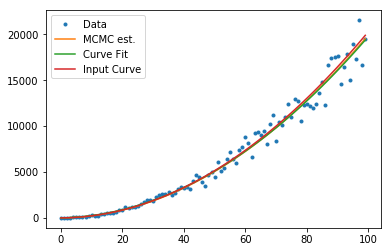

In [88]:
guess = [1.8,2.9,0.8]
yfit = [my_func(i,guess) for i in range(100)]
chisquare = chisq(y,yfit, sigma)
a = []
b = []
c = []
ch = []
xx = []
best = []
bestchsq = chisq(y,yfit, sigma)
for i in range(20000):
    pnew = np.asarray(guess) + np.random.normal(0,0.01,3)
    ynew = [my_func(i,pnew) for i in range(100)]
    chsqnew = chisq(y, ynew, sigma)
    uniform = np.random.uniform()
    if( uniform < chisquare/chsqnew):
        guess = pnew
        #print(i," ",uniform," ",chisquare," ",chsqnew," ",guess)
        chisquare = chsqnew
    if(bestchsq>chsqnew):
        bestchsq = chsqnew
        best = pnew.copy()
    a.append(guess[0])  
    b.append(guess[1])
    c.append(guess[2])
    xx.append(i)

ynew = [my_func(i,best) for i in range(100)]
plt.plot(x,y,'.',label='Data')
plt.plot(x,ynew,'-',label='MCMC est.')
fit, cov = sc.optimize.curve_fit(my_func2,x, y, sigma = sigma_mat)
print("Input Paramters: ",par, " MCMC estimate: ", best, " Curve fit: ", fit)
yfit = [my_func(i,fit) for i in range(100)]
plt.plot(x,yfit,'-',label="Curve Fit")
yinit = [my_func(i,par) for i in range(100)]
print(chisq(y,ynew,sigma)," ",chisq(y,yfit,sigma)," ",chisq(y,yinit,sigma))
plt.plot(x,yinit,'-',label="Input Curve")
plt.legend()
plt.show()
#plt.plot(xx,a)
#plt.show()
#plt.plot(xx,b)
#plt.show()
#plt.plot(xx,c)
#plt.show()



# Now let's try using the numpy leastsq function

In [92]:
def residual(params, xdata, ydata, sigma):
    """Function whose square is to be minimized. 
    
        params: parameters varied to find minimum residual
        xdata:  design matrix
        ydata:  observed data
        sigma:  errors/uncertainty in observed data
    """
    return (ydata-np.dot(xdata, params))/sigma

#Design matrix with column vectors [1,x,x*x]
xdat = []
for i in range(100):
    xdat.append(1)
    xdat.append(i)
    xdat.append(i**2)
xdata = np.asarray(xdat)
#xdata.shape = (100,3)
xdata = np.reshape(xdata,(100,-1))
#print(xdata)
ydata = np.asarray(y)
x0 = np.array([0.0,0.0,0.0])
a,g=opt.leastsq(residual,x0,args=(xdata,ydata,sigma), ftol=1.0e-8)
print(a)
yleastsq = [my_func(i,np.flip(a)) for i in range(100)]
print("Input Paramters: ",par, " MCMC estimate: ", best, " Curve fit: ", fit)

#Let's compare the ChiSquare for the output values from MCMC, scipy.optimize.curve_fit(), numpy.leastsq, and ROOT
#Need to insert values from ROOT for comparison here.
#To obtain values from ROOT open ROOT terminal in this directory and type:
#TGraphErrors *gr = new TGraphErrors("curve.dat");TF1 *f = new TF1("f","pol2",0,100); gr->Fit(f);
#printf("%0.12f, %0.12f, %0.12f\n",f->GetParameter(2),f->GetParameter(1),f->GetParameter(0))
#and the press Enter. Copy and paste the output into parRoot below.
parRoot = (1.966716816883, 2.840714880179, 1.145036803204)
yRoot = [my_func(i,parRoot) for i in range(100)]

#Interesting! np.leastsq() does equal or better than ROOT, but it doesn't give errors on parameters!
print("ChiSquare values  MCMC: ",chisq(y,ynew,sigma)," curve_fit:",chisq(y,yfit,sigma)," leastsq:",chisq(y,yleastsq,sigma),"ROOT: ",chisq(y,yRoot,sigma))

#Sum of squares of residuals is miminimized by scipy.optimize.curve_fit so not surprising it generally beats here!
print("ResSquare values  MCMC: ",ressq(y,ynew)," curve_fit:",ressq(y,yfit)," leastsq:",ressq(y,yleastsq),"ROOT: ",ressq(y,yRoot))

[1.14503731 2.84071444 1.96671683]
Input Paramters:  [2, 3, 1]  MCMC estimate:  [1.9625072  3.04695007 1.1475088 ]  Curve fit:  [ 1.91339474  6.44184706 -1.23028786]
ChiSquare values  MCMC:  138.74316826472352  curve_fit: 643.2768189767451  leastsq: 138.40491031960514 ROOT:  138.40491031962623
ResSquare values  MCMC:  79101418.66509508  curve_fit: 78224721.55759114  leastsq: 79164269.84517129 ROOT:  79164269.73278256
